In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
import calendar
#import prophet
from datetime import datetime
from scipy import stats
import researchpy as rp
from scipy.stats import levene
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

plt.rcParams["figure.figsize"] = (10,8)

In [32]:
df = pd.read_csv('data/01_bikes_casuales.csv', index_col = 0 )
df.head()

,registro,fecha,estacion,año,mes,vacaciones,dia_semana,laborable,clima,temperatura,sensacion_termica,humedad,viento,casuales
0,1,2018-01-01,winter,0,1,1,1,NO,2,14.110847,18.18125,80.5833,10.749882,331
1,2,2018-01-02,winter,0,1,0,2,SI,2,14.902598,17.68695,69.6087,16.652113,131
2,3,2018-01-03,winter,0,1,0,3,SI,1,8.050924,9.47025,43.7273,16.636703,120
3,4,2018-01-04,winter,0,1,0,4,SI,1,8.200000,10.60610,59.0435,10.739832,108
4,5,2018-01-05,winter,0,1,0,5,SI,1,9.305237,11.46350,43.6957,12.522300,82


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   registro           730 non-null    int64  
 1   fecha              730 non-null    object 
 2   estacion           730 non-null    object 
 3   año                730 non-null    int64  
 4   mes                730 non-null    int64  
 5   vacaciones         730 non-null    int64  
 6   dia_semana         730 non-null    int64  
 7   laborable          730 non-null    object 
 8   clima              730 non-null    int64  
 9   temperatura        730 non-null    float64
 10  sensacion_termica  730 non-null    float64
 11  humedad            730 non-null    float64
 12  viento             730 non-null    float64
 13  casuales           730 non-null    int64  
dtypes: float64(4), int64(7), object(3)
memory usage: 85.5+ KB


In [34]:
df.shape

(730, 14)

In [35]:
df.duplicated().sum()

0

In [36]:
df.isnull().sum()

registro             0
fecha                0
estacion             0
año                  0
mes                  0
vacaciones           0
dia_semana           0
laborable            0
clima                0
temperatura          0
sensacion_termica    0
humedad              0
viento               0
casuales             0
dtype: int64

In [37]:
df["vacaciones"] = df["vacaciones"].astype("category")

In [38]:
def detectar_outliers(lista_columnas, dataframe):
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        # calculamos los límites
        outlier_step = 1.5 * IQR
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila.
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
    return dicc_indices

In [39]:
numericas = df.select_dtypes(include = np.number)
columnas = numericas.columns

In [40]:
indices = detectar_outliers(columnas, numericas)

In [45]:
out_casuales = indices["viento"]

Detectamos que en viento y humedad tenemos 

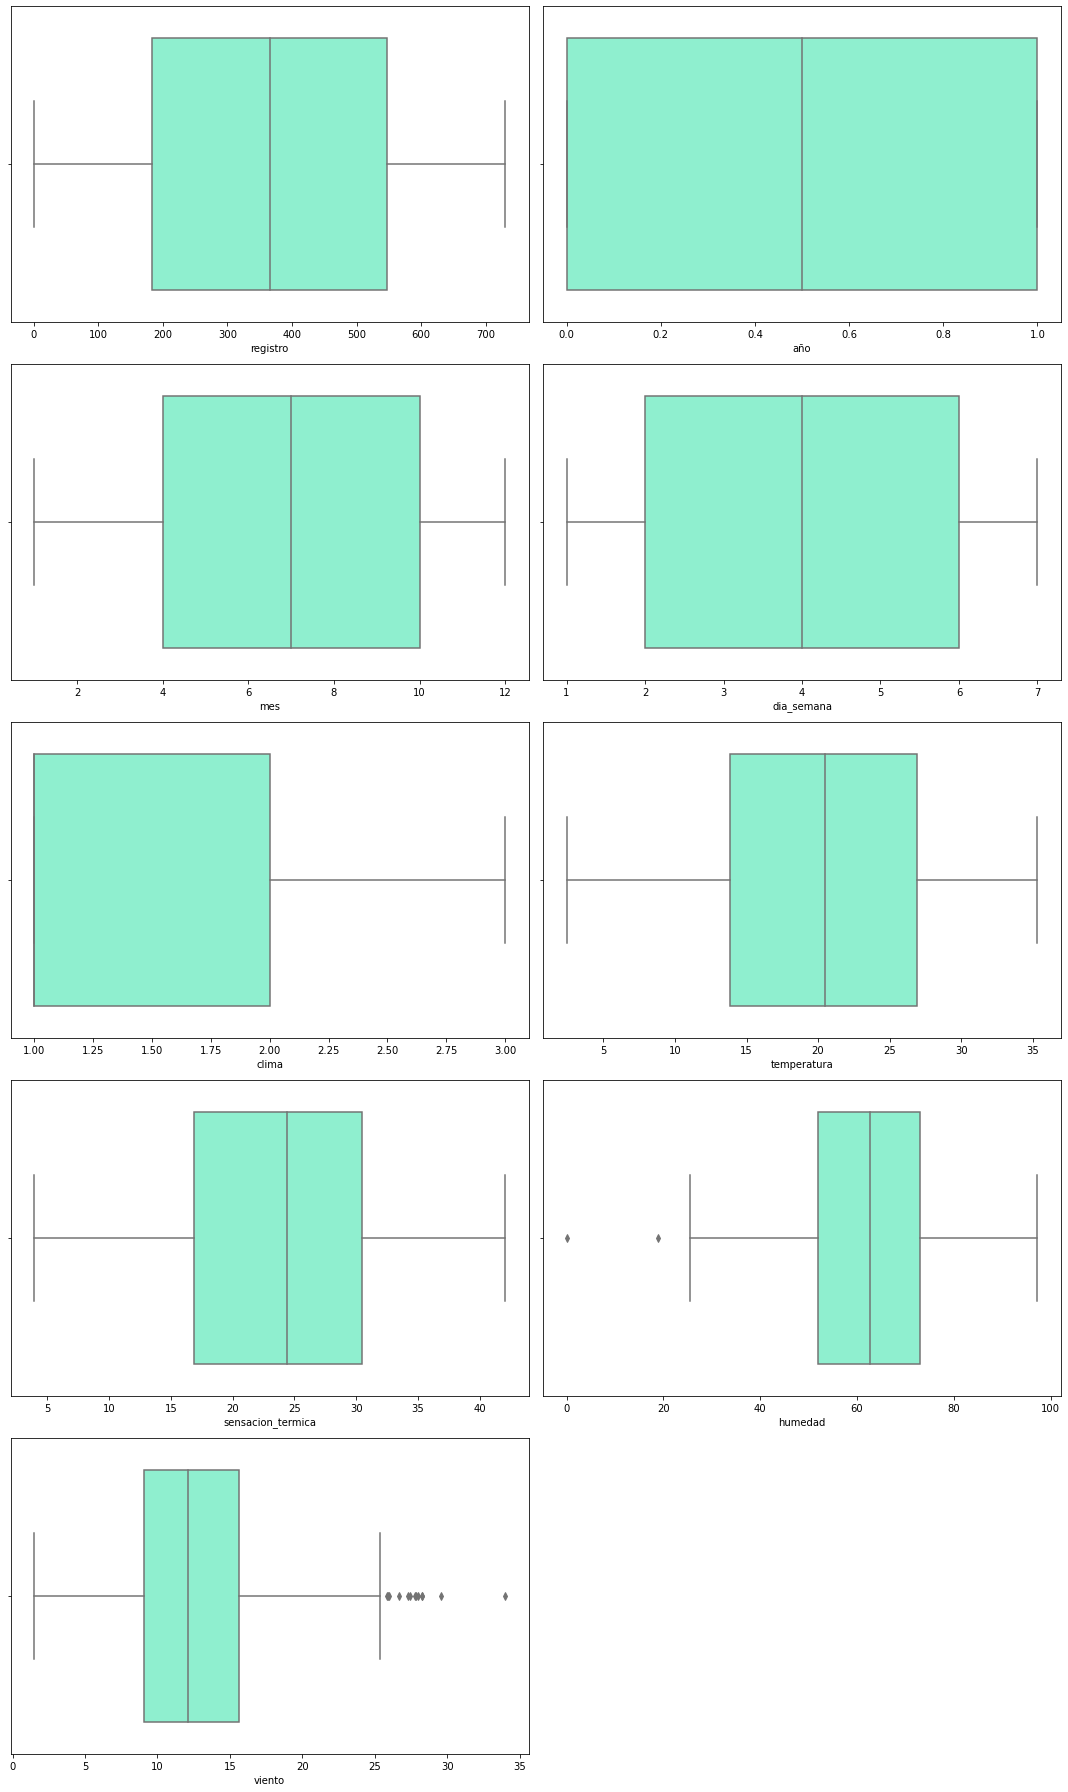

In [42]:
fig, axes = plt.subplots(5, 2, figsize=(15,25))

axes = axes.flat

for indice, columna in enumerate(numericas.columns):
    sns.boxplot(x = numericas[columna], data = df, ax=axes[indice], color = "aquamarine"); # para trazar una línea de densidad

    
plt.tight_layout()
fig.delaxes(axes[-1])
plt.show()


Seria interesante ver que que tienen en común los días en los que los casuales alquilan muchas más bicis

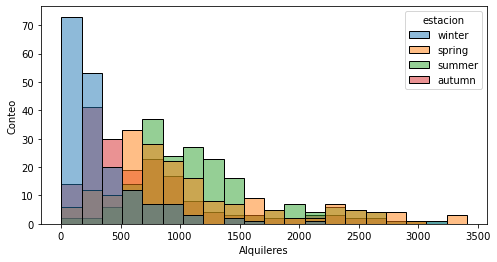

In [46]:
plt.figure(figsize =(8,4))

fig = sns.histplot(x='casuales', data = df, hue = 'estacion')

# establecemos el nombre de los ejes, pero recordad que esto no es obligatorio ya que Seaborn nos los genera automaticamente
fig.set(ylabel='Conteo', xlabel = 'Alquileres')

# Ponemos título a  la gráfica
fig.set_title('')

# mostramos la gráfica
plt.show()


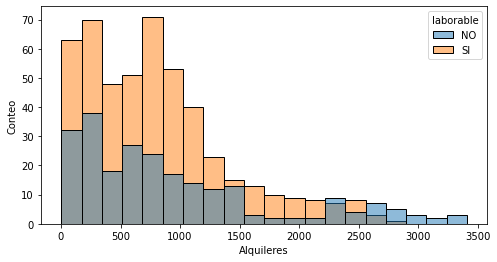

In [47]:
plt.figure(figsize =(8,4))

fig = sns.histplot(x='casuales', data = df, hue = 'laborable')

# establecemos el nombre de los ejes, pero recordad que esto no es obligatorio ya que Seaborn nos los genera automaticamente
fig.set(ylabel='Conteo', xlabel = 'Alquileres')

# Ponemos título a  la gráfica
fig.set_title('')

# mostramos la gráfica
plt.show()

In [ ]:
df.sample()

,registro,fecha,estacion,año,mes,vacaciones,dia_semana,laborable,clima,temperatura,sensacion_termica,humedad,viento,registrados
667,668,2019-10-30,autumn,1,10,0,3,SI,2,13.045462,15.49545,82.5455,14.271603,1009


A primera vista podemos ver que los alquileres casuales tienen más que ver con si es dia laborable o no, más que incluso el tiempo.
A los usuarios registrados les afecta menos si es dia laborable o no.

__________

Miramos las asunciones

In [53]:
df.head()

,registro,fecha,estacion,año,mes,vacaciones,dia_semana,laborable,clima,temperatura,sensacion_termica,humedad,viento,casuales,casuales_raiz
0,1,2018-01-01,winter,0,1,1,1,NO,2,14.110847,18.18125,80.5833,10.749882,331,18.193405
1,2,2018-01-02,winter,0,1,0,2,SI,2,14.902598,17.68695,69.6087,16.652113,131,11.445523
2,3,2018-01-03,winter,0,1,0,3,SI,1,8.050924,9.47025,43.7273,16.636703,120,10.954451
3,4,2018-01-04,winter,0,1,0,4,SI,1,8.200000,10.60610,59.0435,10.739832,108,10.392305
4,5,2018-01-05,winter,0,1,0,5,SI,1,9.305237,11.46350,43.6957,12.522300,82,9.055385


Testeamos la normalidad de la var respuesta

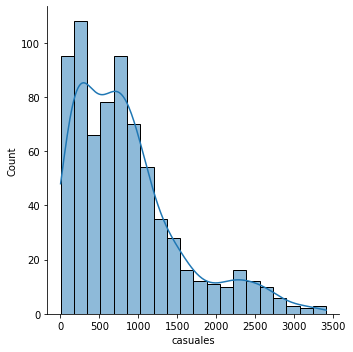

In [48]:
sns.displot(df["casuales"], kde=True)

In [49]:
stats.shapiro(df["casuales"])

ShapiroResult(statistic=0.8850967288017273, pvalue=7.660028716313278e-23)

Los datos no son normales porque son menores de 0.05

Procedemos a normalizar la variable respuesta

Raiz cuadrada

In [ ]:
import math

In [51]:
df["casuales_raiz"] = df["casuales"].apply(lambda x: math.sqrt(x))

In [52]:
stats.shapiro(df["casuales_raiz"])

ShapiroResult(statistic=0.9811134338378906, pvalue=4.261200459154679e-08)

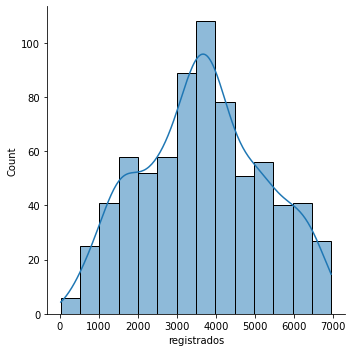

In [ ]:
sns.displot(df["casuales"], kde=True)

Box_cox

In [54]:
df['casuales_box'], lambda_ajustada = stats.boxcox(df['casuales'])


In [55]:
stats.shapiro(df["casuales_box"])

ShapiroResult(statistic=0.9915913939476013, pvalue=0.000365116517059505)

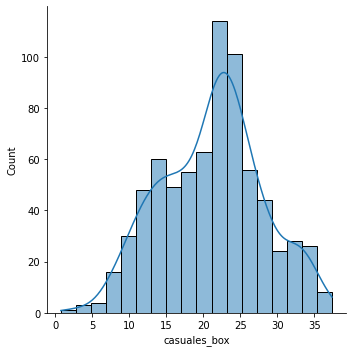

In [56]:
sns.displot(df["casuales_box"], kde=True)

In [57]:
df["casuales_log"] = df["casuales"].apply(lambda x: np.log(x) if x > 0 else 0)

In [58]:
df.head()

,registro,fecha,estacion,año,mes,vacaciones,dia_semana,laborable,clima,temperatura,sensacion_termica,humedad,viento,casuales,casuales_raiz,casuales_box,casuales_log
0,1,2018-01-01,winter,0,1,1,1,NO,2,14.110847,18.18125,80.5833,10.749882,331,18.193405,16.397820,5.802118
1,2,2018-01-02,winter,0,1,0,2,SI,2,14.902598,17.68695,69.6087,16.652113,131,11.445523,11.472437,4.875197
2,3,2018-01-03,winter,0,1,0,3,SI,1,8.050924,9.47025,43.7273,16.636703,120,10.954451,11.076035,4.787492
3,4,2018-01-04,winter,0,1,0,4,SI,1,8.200000,10.60610,59.0435,10.739832,108,10.392305,10.613970,4.682131
4,5,2018-01-05,winter,0,1,0,5,SI,1,9.305237,11.46350,43.6957,12.522300,82,9.055385,9.475537,4.406719


In [59]:
stats.shapiro(df["casuales_log"])

ShapiroResult(statistic=0.9472163915634155, pvalue=1.8073885266976222e-15)

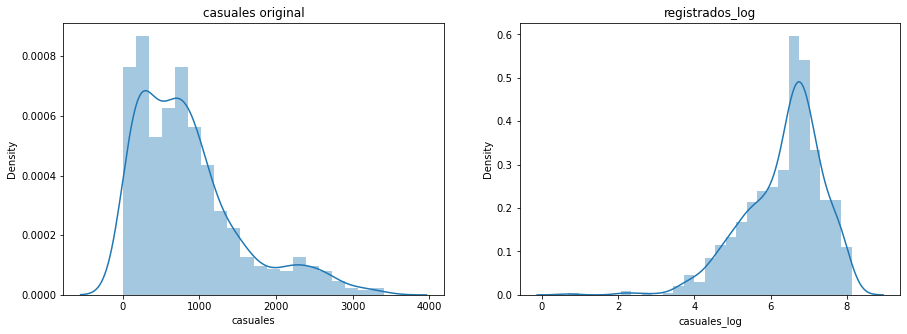

In [60]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('casuales original')
axes[1].set_title('registrados_log')

sns.distplot(df["casuales"] ,ax = axes[0])
sns.distplot(df["casuales_log"], ax = axes[1]);

#### Conclusion:

Observamos que nuestro p_valor > 0.05 nuestros datos NO son normales. 

- Min Scaler

In [61]:
minmax = MinMaxScaler()
minmax.fit(df[['casuales']])

MinMaxScaler()

In [63]:
X_normalizadas = minmax.transform(df[['casuales']])

In [64]:
X_normalizadas.min(axis=0)

array([0.])

In [65]:
X_normalizadas.max(axis=0)

array([1.])

In [66]:
numericas_minmax= pd.DataFrame(X_normalizadas, columns= ['casuales'])
numericas_minmax.head()

,casuales
0,0.096538
1,0.037852
2,0.034624
3,0.031103
4,0.023474


In [67]:
df['casuales_min_max'] = numericas_minmax
df.head()

,registro,fecha,estacion,año,mes,vacaciones,dia_semana,laborable,clima,temperatura,sensacion_termica,humedad,viento,casuales,casuales_raiz,casuales_box,casuales_log,casuales_min_max
0,1,2018-01-01,winter,0,1,1,1,NO,2,14.110847,18.18125,80.5833,10.749882,331,18.193405,16.397820,5.802118,0.096538
1,2,2018-01-02,winter,0,1,0,2,SI,2,14.902598,17.68695,69.6087,16.652113,131,11.445523,11.472437,4.875197,0.037852
2,3,2018-01-03,winter,0,1,0,3,SI,1,8.050924,9.47025,43.7273,16.636703,120,10.954451,11.076035,4.787492,0.034624
3,4,2018-01-04,winter,0,1,0,4,SI,1,8.200000,10.60610,59.0435,10.739832,108,10.392305,10.613970,4.682131,0.031103
4,5,2018-01-05,winter,0,1,0,5,SI,1,9.305237,11.46350,43.6957,12.522300,82,9.055385,9.475537,4.406719,0.023474


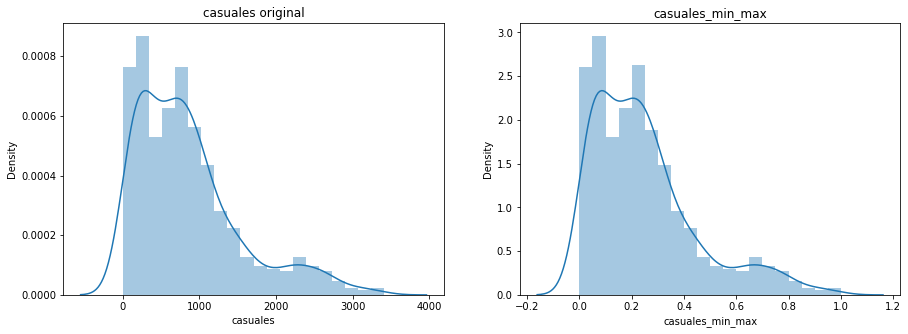

In [68]:

fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('casuales original')
axes[1].set_title('casuales_min_max')

sns.distplot(df['casuales'] ,ax = axes[0])
sns.distplot(df['casuales_min_max'], ax = axes[1]);

In [69]:
stats.shapiro(df["casuales_min_max"])

ShapiroResult(statistic=0.8850969076156616, pvalue=7.660317123860226e-23)

#### Conclusiones:

Observamos que nuestro p_valor > 0.05 nuestros datos NO son normales. 

In [71]:
#Borramos las columnas que no necesitamos 
df.drop(['casuales_raiz','casuales_box', 'casuales_log', 'casuales_min_max'], axis=1, inplace=True )

In [73]:
df.head(2)

,registro,fecha,estacion,año,mes,vacaciones,dia_semana,laborable,clima,temperatura,sensacion_termica,humedad,viento,casuales
0,1,2018-01-01,winter,0,1,1,1,NO,2,14.110847,18.18125,80.5833,10.749882,331
1,2,2018-01-02,winter,0,1,0,2,SI,2,14.902598,17.68695,69.6087,16.652113,131
